In [9]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [10]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/src/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


#### 2. Sample the `graph`

In [11]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

/Users/badw/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1008it [00:50, 19.81it/s]                         


#### 3. generate reaction statistics

In [12]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2 + 1 SO2 = 1 O2 + 1 H2S              345
1 H2O + 1 SO2 = 1 H2SO3                  335
2 H2 + 1 O2 = 2 H2O                      266
3 H2 + 1 SO2 = 2 H2O + 1 H2S             164
3 O2 + 2 H2S = 2 H2O + 2 SO2             139
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO    119
1 H2 + 1 NO2 = 1 H2O + 1 NO              116
1 H2O + 1 NO2 + 1 NO = 2 HNO2            112
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2            84
2 H2 + 2 SO2 + 1 N2 = 2 H2S + 2 NO2       75
dtype: int64

#### 4. generate mean concentrations and differences

In [14]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

        initial   mean  diff   sem   std    var
H2S        10.0   4.88 -5.12  0.10  4.75  22.53
NO2        10.0   6.19 -3.81  0.10  4.85  23.48
O2         10.0   6.24 -3.76  0.12  5.76  33.18
S8          0.0   0.07  0.07  0.01  0.26   0.07
NH3         0.0   0.12  0.12  0.02  0.85   0.73
NOHSO4      0.0   0.17  0.17  0.02  0.94   0.89
HNO3        0.0   0.45  0.45  0.03  1.52   2.30
HNO2        0.0   0.48  0.48  0.04  1.78   3.17
H2O        30.0  30.48  0.48  0.11  5.51  30.31
H2SO3       0.0   0.51  0.51  0.04  2.17   4.71
N2          0.0   0.54  0.54  0.03  1.53   2.33
H2SO4       0.0   0.65  0.65  0.05  2.47   6.08
NO          0.0   1.45  1.45  0.07  3.45  11.89
H2          0.0   2.19  2.19  0.08  4.04  16.32
SO2        10.0  12.65  2.65  0.11  5.55  30.82


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_68929/949321809.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



<Axes: >

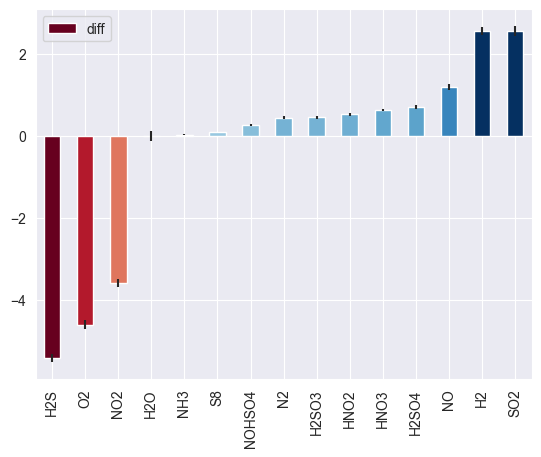

In [22]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [ ]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white'}
g = analysis.result_to_pyvis(data,head=10)
g.save_graph(name="example_pyvis_graph.html")